In [1]:
# Importe pacotes

import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import shutil

In [2]:
# Importe funções e classes

from src.utils import *
from src.preprocessdataset import *
from src.unet import *
from src.unettrainer import *

In [3]:
# Definindo os caminhos para cada conjunto
dir_dataset = "data\CamVid"

class_dict = os.path.join(dir_dataset, 'class_dict.csv')
df_labels = pd.read_csv(class_dict)

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Isas_\AppData\Local\Temp\ipykernel_15768\1657100305.py:2: SyntaxWarning: invalid escape sequence '\C'
  dir_dataset = "data\CamVid"


In [4]:
remove_all_files_from_dir("debug_processed_data")
# Parâmetros
partition = 3  # Reduzir o tamanho da imagem por um fator de 3
prob_train = 0.25  # Probabilidade de aplicar transformações no conjunto de treino
prob_others = 0.10  # Probabilidade de aplicar transformações nos conjuntos de validação e teste
dir_new_dataset = "debug_processed_data"  # Diretório onde os conjuntos processados serão salvos
with_brightness_contrast = True  # Aplicar transformações de brilho e contraste
var_gaussian = 20  # Variância do ruído gaussiano
amount = 0.02  # Quantidade de ruído sal e pimenta

# Criando o dataset para o conjunto de treino
train_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='train',  # Carrega o conjunto de treino
    partition=partition  # Reduzir a imagem por um fator de 4
)

# Criando o dataset para o conjunto de validação
val_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='val',  # Carrega o conjunto de validação
    partition=partition
)

# Criando o dataset para o conjunto de teste
test_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='test',  # Carrega o conjunto de teste
    partition=partition
)

# Definindo o tamanho do batch
batch_size = 24

# Criando o DataLoader para o conjunto de treino
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Criando o DataLoader para o conjunto de validação
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Criando o DataLoader para o conjunto de teste
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Número de batches de treino: {len(train_loader)}')
print(f'Número de batches de validação: {len(val_loader)}')
print(f'Número de batches de teste: {len(test_loader)}')

# Iterando sobre o DataLoader de treino
for images, labels in train_loader:
    print(f'Batch de imagens: {images.shape}')
    print(f'Batch de labels: {labels.shape}')
    # Aqui você pode passar as imagens e labels para o seu modelo
    break  # Apenas um exemplo, interrompendo após o primeiro batch

Número de batches de treino: 22
Número de batches de validação: 6
Número de batches de teste: 14
Batch de imagens: torch.Size([24, 3, 240, 320])
Batch de labels: torch.Size([24, 240, 320])


In [5]:
# Instanciando o modelo U-Net com as dimensões das imagens
model = UNet(image_dim=(3, 240, 320), n_channels=64, n_classes=32, depth=3, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
# Configurando o dispositivo (GPU, se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
model = model.to(device)  # Mover o modelo para o dispositivo

# Testando com um batch de dados do DataLoader
for images, labels in train_loader:
    # Move os dados para o dispositivo (GPU/CPU)
    images = images.to(device)
    labels = labels.to(device)
    print("Imagens e rótulos movidos para o dispositivo.")
    print(images.shape)
    print(labels.shape)
    print("Iniciando forward pass...")
    # Passa as imagens pelo modelo U-Net
    output = model(images)
    
    # Exibe as dimensões das imagens, labels e da saída do modelo
    print(f"Imagens: {images.shape}")
    print(f"Labels: {labels.shape}")
    print(f"Saída do modelo: {output.shape}")
    
    # Quebrar após o primeiro batch, apenas para teste
    break

Dispositivo: cuda
Imagens e rótulos movidos para o dispositivo.
torch.Size([24, 3, 240, 320])
torch.Size([24, 240, 320])
Iniciando forward pass...
Imagens: torch.Size([24, 3, 240, 320])
Labels: torch.Size([24, 240, 320])
Saída do modelo: torch.Size([24, 32, 240, 320])


Dispositivo em uso: cuda
Criando o modelo U-Net...
Modelo U-Net criado.
Iniciando treinamento...
Número de batches de treino: 33
Gerando os dicionários de mapeamento...
Criando o DataLoader de treino...
Iniciando treinamento...
Epoch [1/25], Loss: 2.0934, Accuracy: 57.13%
Validation Loss: 2.5132, Validation Accuracy: 44.64%


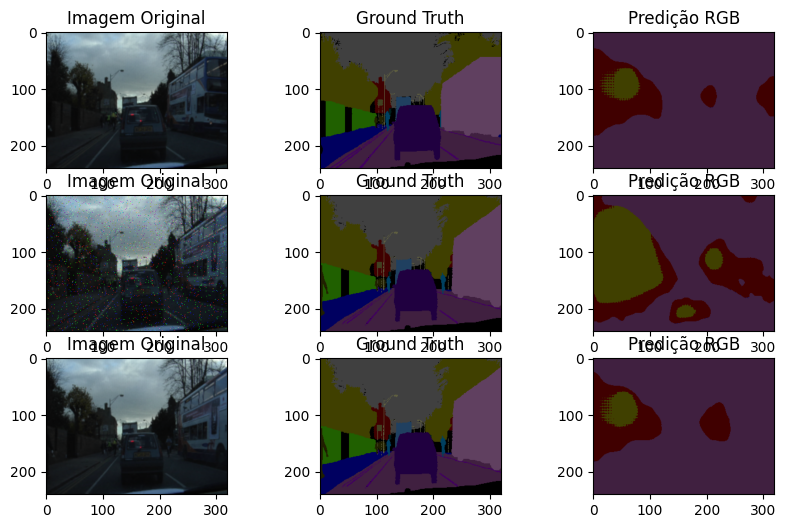

Epoch [2/25], Loss: 1.3595, Accuracy: 66.41%
Validation Loss: 1.3642, Validation Accuracy: 62.78%
Epoch [3/25], Loss: 1.0828, Accuracy: 71.22%
Validation Loss: 1.1262, Validation Accuracy: 70.43%
Epoch [4/25], Loss: 0.9552, Accuracy: 74.46%
Validation Loss: 1.0209, Validation Accuracy: 71.01%
Epoch [5/25], Loss: 0.9303, Accuracy: 74.27%
Validation Loss: 0.9431, Validation Accuracy: 73.74%
Epoch [6/25], Loss: 0.8413, Accuracy: 76.64%
Validation Loss: 0.8269, Validation Accuracy: 76.97%


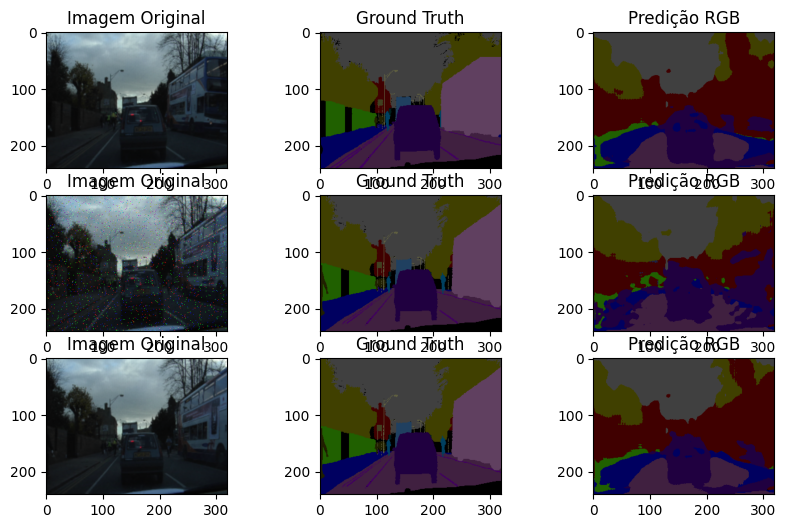

Epoch [7/25], Loss: 0.7930, Accuracy: 78.32%
Validation Loss: 0.8495, Validation Accuracy: 76.18%
Epoch [8/25], Loss: 0.7668, Accuracy: 78.31%
Validation Loss: 0.7746, Validation Accuracy: 78.17%
Epoch [9/25], Loss: 0.7240, Accuracy: 79.35%
Validation Loss: 0.8026, Validation Accuracy: 77.21%
Epoch [10/25], Loss: 0.6901, Accuracy: 80.37%
Validation Loss: 0.7142, Validation Accuracy: 80.13%
Epoch [11/25], Loss: 0.6875, Accuracy: 80.62%
Validation Loss: 0.6960, Validation Accuracy: 80.11%


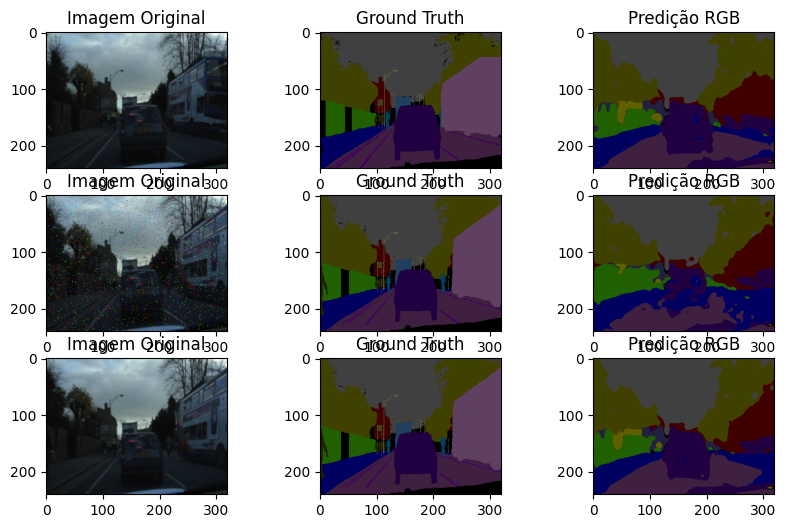

Epoch [12/25], Loss: 0.7078, Accuracy: 79.54%
Validation Loss: 0.7192, Validation Accuracy: 79.62%
Epoch [13/25], Loss: 0.6528, Accuracy: 80.99%
Validation Loss: 0.7324, Validation Accuracy: 78.46%
Epoch [14/25], Loss: 0.6212, Accuracy: 81.76%
Validation Loss: 0.7108, Validation Accuracy: 79.49%
Epoch [15/25], Loss: 0.6370, Accuracy: 81.93%
Validation Loss: 1.5798, Validation Accuracy: 66.30%
Epoch [16/25], Loss: 0.6158, Accuracy: 81.81%
Validation Loss: 0.8747, Validation Accuracy: 69.86%


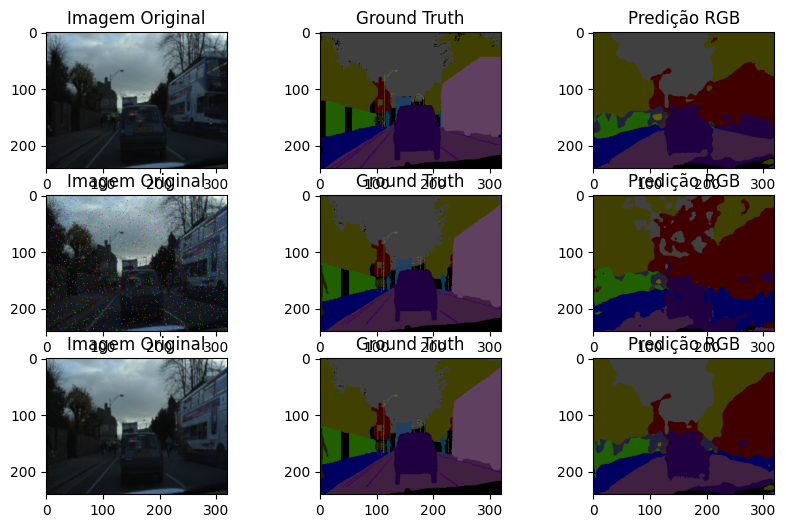

Epoch [17/25], Loss: 0.5798, Accuracy: 83.05%
Validation Loss: 0.6562, Validation Accuracy: 81.06%
Epoch [18/25], Loss: 0.5684, Accuracy: 83.12%
Validation Loss: 0.6268, Validation Accuracy: 81.98%
Epoch [19/25], Loss: 0.5413, Accuracy: 83.96%
Validation Loss: 0.6418, Validation Accuracy: 81.23%
Epoch [20/25], Loss: 0.5407, Accuracy: 83.88%
Validation Loss: 0.7718, Validation Accuracy: 78.32%
Epoch [21/25], Loss: 0.5298, Accuracy: 83.93%
Validation Loss: 0.6368, Validation Accuracy: 82.46%


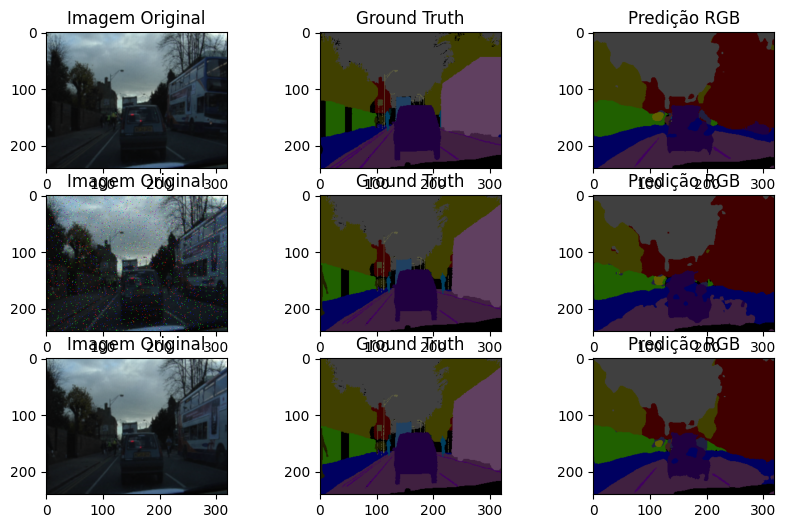

Epoch [22/25], Loss: 0.5294, Accuracy: 84.37%
Validation Loss: 1.0441, Validation Accuracy: 72.33%
Epoch [23/25], Loss: 0.5745, Accuracy: 82.98%
Validation Loss: 0.7945, Validation Accuracy: 77.20%
Epoch [24/25], Loss: 0.5671, Accuracy: 83.09%
Validation Loss: 0.6084, Validation Accuracy: 82.12%
Epoch [25/25], Loss: 0.5211, Accuracy: 84.43%
Validation Loss: 0.6317, Validation Accuracy: 81.45%


{'train_loss': [2.093445492513252,
  1.3595399206334895,
  1.0827599601312117,
  0.9551521918990395,
  0.9303341074423357,
  0.8413434389865759,
  0.7930472547357733,
  0.7667611169092583,
  0.7239956006859288,
  0.6901475552356604,
  0.6874736222353849,
  0.7077759811372468,
  0.6528424169078018,
  0.621205002972574,
  0.6370403703415033,
  0.6157561522541624,
  0.5798226477521838,
  0.5684362162243236,
  0.5413308631290089,
  0.5406565214648391,
  0.5297627123919401,
  0.5293624283689441,
  0.5744769916389928,
  0.5670566007946477,
  0.5210989957506006],
 'val_loss': [2.513244973288642,
  1.3641826179292467,
  1.1262282795376248,
  1.0209322108162775,
  0.9430997106764052,
  0.8268669843673706,
  0.8495397037929959,
  0.7745683193206787,
  0.8025832441118028,
  0.7142232921388414,
  0.6960436900456747,
  0.7191807760132684,
  0.7323670056131151,
  0.7108211252424452,
  1.5797846913337708,
  0.8746567964553833,
  0.6561766266822815,
  0.6268100672298007,
  0.6418419910801781,
  0.7718

In [6]:
# Exemplo de uso
image_dim = (3, 240, 320)
n_channels = 64
n_classes = 32

# Verificar se a GPU está disponível e usar o dispositivo adequado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo em uso: {device}")

print("Criando o modelo U-Net...")
# Definir o modelo
model = UNet(image_dim=image_dim, n_channels=n_channels, n_classes=n_classes)
print("Modelo U-Net criado.")


# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Iniciando treinamento...")
# Carregar os DataLoaders (substitua pelos seus datasets reais)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Número de batches de treino: {len(train_loader)}')
# Carregar o dicionário de classes
dir_dataset = "data/CamVid"  # Verifique o caminho correto para seu dataset
class_dict_path = os.path.join(dir_dataset, 'class_dict.csv')
class_dict = pd.read_csv(class_dict_path)

print("Gerando os dicionários de mapeamento...")
# Gerar os dicionários de mapeamento
rgb_to_index, index_to_label = dict_labels(class_dict)

print("Criando o DataLoader de treino...")
# Instanciar a classe de treinamento
trainer = UNetTrainer(model, train_loader, val_loader, test_loader, rgb_to_index, index_to_label, optimizer, criterion, device=device)

print("Iniciando treinamento...")
# Treinar o modelo por 25 épocas
trainer.train(num_epochs=25)


3

Teste multi-label margin loss e average pooling.

In [4]:
remove_all_files_from_dir("debug_processed_data")
# Parâmetros
partition = 3  # Reduzir o tamanho da imagem por um fator de 3
prob_train = 0.25  # Probabilidade de aplicar transformações no conjunto de treino
prob_others = 0.10  # Probabilidade de aplicar transformações nos conjuntos de validação e teste
dir_new_dataset = "debug_processed_data"  # Diretório onde os conjuntos processados serão salvos
with_brightness_contrast = True  # Aplicar transformações de brilho e contraste
var_gaussian = 20  # Variância do ruído gaussiano
amount = 0.02  # Quantidade de ruído sal e pimenta

# Criando o dataset para o conjunto de treino
train_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='train',  # Carrega o conjunto de treino
    partition=partition  # Reduzir a imagem por um fator de 4
)

# Criando o dataset para o conjunto de validação
val_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='val',  # Carrega o conjunto de validação
    partition=partition
)

# Criando o dataset para o conjunto de teste
test_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='test',  # Carrega o conjunto de teste
    partition=partition
)

# Definindo o tamanho do batch
batch_size = 24

# Criando o DataLoader para o conjunto de treino
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Criando o DataLoader para o conjunto de validação
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Criando o DataLoader para o conjunto de teste
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Número de batches de treino: {len(train_loader)}')
print(f'Número de batches de validação: {len(val_loader)}')
print(f'Número de batches de teste: {len(test_loader)}')

# Iterando sobre o DataLoader de treino
for images, labels in train_loader:
    print(f'Batch de imagens: {images.shape}')
    print(f'Batch de labels: {labels.shape}')
    # Aqui você pode passar as imagens e labels para o seu modelo
    break  # Apenas um exemplo, interrompendo após o primeiro batch

Número de batches de treino: 22
Número de batches de validação: 6
Número de batches de teste: 14
Batch de imagens: torch.Size([24, 3, 240, 320])
Batch de labels: torch.Size([24, 240, 320])


In [5]:
# Instanciando o modelo U-Net com as dimensões das imagens
model = UNet(image_dim=(3, 240, 320), n_channels=64, n_classes=32, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
model.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
# Configurando o dispositivo (GPU, se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
model = model.to(device)  # Mover o modelo para o dispositivo

# Testando com um batch de dados do DataLoader
for images, labels in train_loader:
    # Move os dados para o dispositivo (GPU/CPU)
    images = images.to(device)
    labels = labels.to(device)
    print("Imagens e rótulos movidos para o dispositivo.")
    print(images.shape)
    print(labels.shape)
    print("Iniciando forward pass...")
    # Passa as imagens pelo modelo U-Net
    output = model(images)
    
    # Exibe as dimensões das imagens, labels e da saída do modelo
    print(f"Imagens: {images.shape}")
    print(f"Labels: {labels.shape}")
    print(f"Saída do modelo: {output.shape}")
    
    # Quebrar após o primeiro batch, apenas para teste
    break

Dispositivo: cuda
Imagens e rótulos movidos para o dispositivo.
torch.Size([24, 3, 240, 320])
torch.Size([24, 240, 320])
Iniciando forward pass...
Imagens: torch.Size([24, 3, 240, 320])
Labels: torch.Size([24, 240, 320])
Saída do modelo: torch.Size([24, 32, 240, 320])


Dispositivo em uso: cuda
Criando o modelo U-Net...
Modelo U-Net criado.
Iniciando treinamento...
Número de batches de treino: 33
Gerando os dicionários de mapeamento...
Criando o DataLoader de treino...
Iniciando treinamento...
Epoch [1/25], Loss: 2.1815, Accuracy: 55.66%
Validation Loss: 2.3901, Validation Accuracy: 43.52%


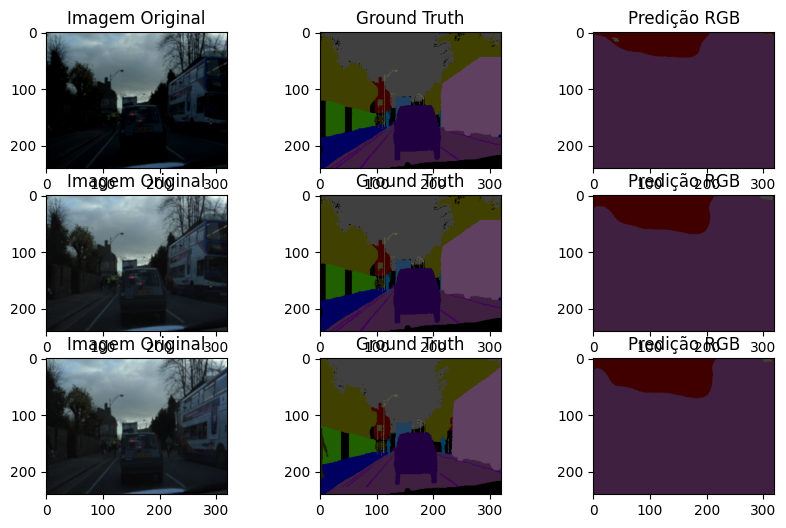

Epoch [2/25], Loss: 1.3490, Accuracy: 65.69%
Validation Loss: 1.2506, Validation Accuracy: 66.69%
Epoch [3/25], Loss: 1.1454, Accuracy: 68.53%
Validation Loss: 1.1050, Validation Accuracy: 68.18%
Epoch [4/25], Loss: 0.9972, Accuracy: 72.64%
Validation Loss: 1.2926, Validation Accuracy: 58.00%
Epoch [5/25], Loss: 0.8964, Accuracy: 75.74%
Validation Loss: 0.8714, Validation Accuracy: 76.70%
Epoch [6/25], Loss: 0.8179, Accuracy: 77.78%
Validation Loss: 0.8544, Validation Accuracy: 76.34%


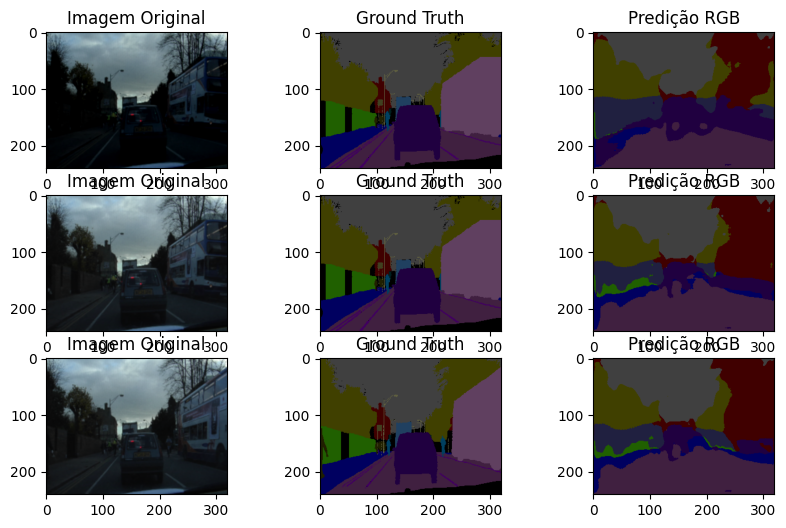

Epoch [7/25], Loss: 0.7878, Accuracy: 78.14%
Validation Loss: 0.8457, Validation Accuracy: 76.43%
Epoch [8/25], Loss: 0.7745, Accuracy: 78.14%
Validation Loss: 1.1915, Validation Accuracy: 69.58%
Epoch [9/25], Loss: 0.7400, Accuracy: 79.02%
Validation Loss: 0.7244, Validation Accuracy: 79.71%
Epoch [10/25], Loss: 0.7074, Accuracy: 79.71%
Validation Loss: 0.7259, Validation Accuracy: 79.34%
Epoch [11/25], Loss: 0.6813, Accuracy: 80.38%
Validation Loss: 0.7969, Validation Accuracy: 77.32%


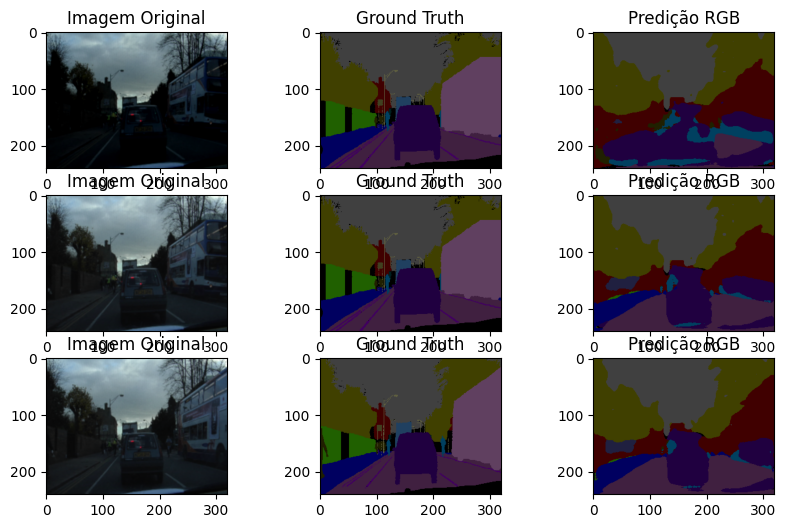

Epoch [12/25], Loss: 0.6395, Accuracy: 81.40%
Validation Loss: 0.7454, Validation Accuracy: 76.88%
Epoch [13/25], Loss: 0.6333, Accuracy: 81.63%
Validation Loss: 0.8086, Validation Accuracy: 76.46%
Epoch [14/25], Loss: 0.6001, Accuracy: 82.42%
Validation Loss: 0.6200, Validation Accuracy: 82.15%
Epoch [15/25], Loss: 0.5854, Accuracy: 82.79%
Validation Loss: 1.3708, Validation Accuracy: 68.92%
Epoch [16/25], Loss: 0.5697, Accuracy: 83.17%
Validation Loss: 0.6364, Validation Accuracy: 82.05%


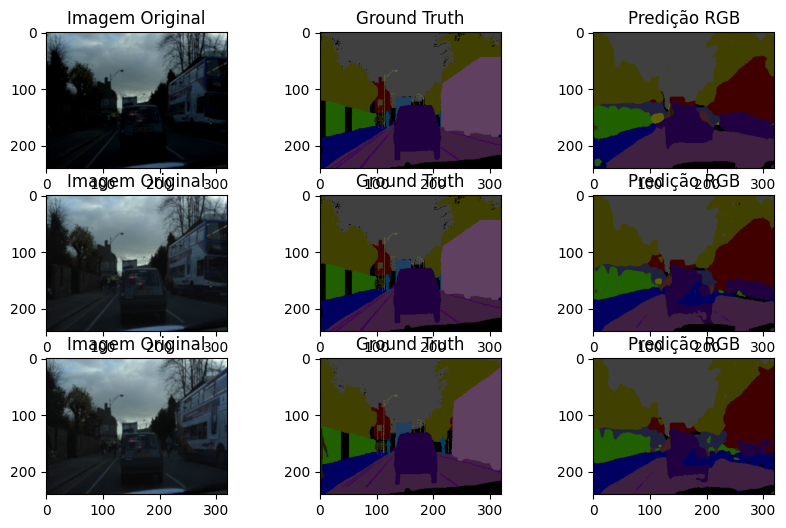

Epoch [17/25], Loss: 0.5602, Accuracy: 83.47%
Validation Loss: 0.6156, Validation Accuracy: 82.17%
Epoch [18/25], Loss: 0.5362, Accuracy: 84.10%
Validation Loss: 0.5945, Validation Accuracy: 82.91%
Epoch [19/25], Loss: 0.5088, Accuracy: 84.81%
Validation Loss: 0.5680, Validation Accuracy: 83.64%
Epoch [20/25], Loss: 0.4957, Accuracy: 85.10%
Validation Loss: 0.5708, Validation Accuracy: 83.47%
Epoch [21/25], Loss: 0.4956, Accuracy: 85.00%
Validation Loss: 0.5681, Validation Accuracy: 83.76%


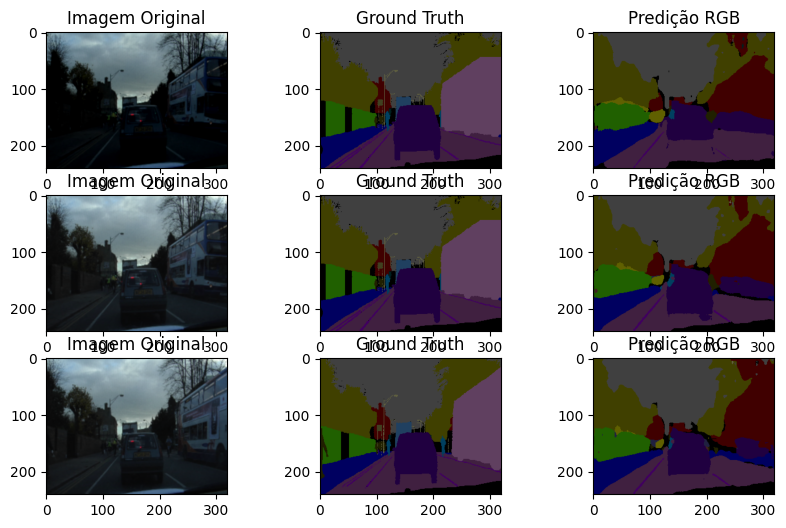

Epoch [22/25], Loss: 0.4849, Accuracy: 85.41%
Validation Loss: 0.5642, Validation Accuracy: 83.39%
Epoch [23/25], Loss: 0.4827, Accuracy: 85.33%
Validation Loss: 1.0492, Validation Accuracy: 70.36%
Epoch [24/25], Loss: 0.5553, Accuracy: 83.28%
Validation Loss: 1.3002, Validation Accuracy: 69.21%
Epoch [25/25], Loss: 0.5088, Accuracy: 84.56%
Validation Loss: 0.5470, Validation Accuracy: 84.06%


{'train_loss': [2.1814626635927143,
  1.3489930882598415,
  1.1454024784492725,
  0.9971525578787832,
  0.896357308734547,
  0.8178836360122218,
  0.7877719384251218,
  0.7744894894686613,
  0.739983031243989,
  0.7074178258577982,
  0.6812696854273478,
  0.6395028125156056,
  0.633261117068204,
  0.6001348341956283,
  0.5853885954076593,
  0.5697120951883721,
  0.5601924170147289,
  0.536157286528385,
  0.5087837242718899,
  0.49569548892252374,
  0.4956426439863263,
  0.4849392329201554,
  0.4827118389534228,
  0.5552700053561818,
  0.5087787238034335],
 'val_loss': [2.3900711271497936,
  1.2505768140157063,
  1.1050418747795954,
  1.292646262380812,
  0.8714316354857551,
  0.8544342981444465,
  0.8456695278485616,
  1.191527909702725,
  0.7243591017193265,
  0.72588625881407,
  0.7969043784671359,
  0.7454469071494209,
  0.808567550447252,
  0.6199726230568356,
  1.3708495034111872,
  0.6364111304283142,
  0.6156311697430081,
  0.5944730010297563,
  0.5680395232306586,
  0.570812533

In [6]:
# Exemplo de uso
image_dim = (3, 240, 320)
n_channels = 64
n_classes = 32

# Verificar se a GPU está disponível e usar o dispositivo adequado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo em uso: {device}")

print("Criando o modelo U-Net...")
# Definir o modelo
model = UNet(image_dim=image_dim, n_channels=n_channels, n_classes=n_classes)
print("Modelo U-Net criado.")


# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Iniciando treinamento...")
# Carregar os DataLoaders (substitua pelos seus datasets reais)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Número de batches de treino: {len(train_loader)}')
# Carregar o dicionário de classes
dir_dataset = "data/CamVid"  # Verifique o caminho correto para seu dataset
class_dict_path = os.path.join(dir_dataset, 'class_dict.csv')
class_dict = pd.read_csv(class_dict_path)

print("Gerando os dicionários de mapeamento...")
# Gerar os dicionários de mapeamento
rgb_to_index, index_to_label = dict_labels(class_dict)

print("Criando o DataLoader de treino...")
# Instanciar a classe de treinamento
trainer = UNetTrainer(model, train_loader, val_loader, test_loader, rgb_to_index, index_to_label, optimizer, criterion, device=device)

print("Iniciando treinamento...")
# Treinar o modelo por 25 épocas
trainer.train(num_epochs=25)
